# Evaluate LLM4SYN outputs

### 1. Imports
We start by importing the necessary libraries:
- **Standard libraries**: Used for basic file operations and random number generation.
- **Third-party libraries**: `pandas` for data manipulation, `numpy` for numerical operations, and `matplotlib` for plotting.
- **Custom modules**: These are specific to this project and contain functions for handling data configurations, evaluations, metrics, and outputs.

### 2. Configuration
Here, we configure the environment:
- **Matplotlib**: Set the font to Arial for consistency in all plots.
- **Random seed**: Set a seed value for reproducibility across different runs.


In [2]:
# Standard library imports
import os
import random
from os.path import join

# Third-party imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Custom module imports (local utilities)
from env_config import hf_load_name, seedn, save_dir, fig_dir
from utils.data_config import separator_dict, full_equation_dict, arrow_l2r
from utils.evaluate import find_atomic_species, save_dict_as_csv
from utils.metrics import equation_similarity, jaccard_similarity
from utils.utilities import chemical_symbols
from utils.output import good_colors, generate_latex_table

# Configure Matplotlib settings for plots
plt.rcParams['font.family'] = ['Arial', 'sans-serif']

# Configuration: Setting random seed for reproducibility
random.seed(seedn)


### Hyperparameters and Paths Explanation:
1. **Task and Model Configuration**: 
   - `task`: Specifies the type of task (e.g., equation generation or token prediction).
   - `model_tag`: Specifies the model being used (e.g., `dgpt2` for a fine-tuned GPT-2 model).
   - `ver_tag` and `file_tag`: Used to version the model and differentiate between model variants or evaluation runs.
   
2. **Equation and Separator Settings**: 
   - `arrow`: This defines the arrow symbol used in the equations (e.g., `->`).
   - `separator_dict`: Maps tasks to separators used in splitting or parsing equations.

3. **Paths and File Saving**:
   - `run_name`: Combines task, model, and version information into a single identifier for the run.
   - `model_name`: Path to the model's directory (used for loading pre-trained models).
   - `save_header` and `csv_load_file`: Used for constructing paths to save and load results.


In [22]:
# # Hyperparameters and Paths

# Task and Model Configuration
task = 'tgtope2ceq'    # Task type for evaluation
model_tag = 'dgpt2'    # Model name/tag (e.g., GPT-2 variant)
ver_tag = 'v1.2.1'     # Version tag for the model being evaluated
file_tag = '-1.1'      # File tag for saving/loading results

# Equation and Separator Configuration
arrow = arrow_l2r      # Arrow symbol used in the task ('->')
separator, cut = separator_dict[task], ';'  # Separators used in equations for this task

# Run and Model Names
run_name = f'{task}_{model_tag}_{ver_tag}'  # Run name combining task, model, and version
model_name = join(hf_load_name, run_name)   # Full path to the pre-trained model directory

# File Paths for Loading and Saving Results
save_header = f'{run_name}{file_tag}'  # Header for saved files (used for consistency)
csv_load_file = join('save', f"{save_header}_test_n1948.csv")  # CSV file with evaluation data


### 3. Loading Evaluation Data

In this step, we load the evaluation data (saved as a CSV file) for further analysis. This data contains model outputs and ground truth comparisons.


In [4]:
# Load the CSV file containing evaluation data
data = pd.read_csv(csv_load_file)

# Display the first few rows of the data to verify successful loading
data.head()

### 4. Defining Evaluation Metrics

In this section, we define the metrics that will be used to evaluate the model outputs. Specifically, we are using two metrics: 
- `gts` (Generalized Tanimoto Similarity)
- `js` (Jaccard Similarity)

We also set up the necessary arguments (e.g., task-specific configuration) that will be passed to these metrics during evaluation.


In [5]:
# Define metrics for evaluation
# 'gts' -> Generalized Tanimoto Similarity
# 'js'  -> Jaccard Similarity 
metrics_dict = {
    'gts': equation_similarity,  # Generalized Tanimoto Similarity metric
    'js': jaccard_similarity      # Jaccard Similarity metric
}

# Extract the metric keys (e.g., 'gts', 'js')
metrics_key = list(metrics_dict.keys())

# Additional arguments to pass to each metric function
metrics_kwargs_dict = {
    'gts': {'whole_equation': full_equation_dict[task], 'split': arrow},  # Task-specific kwargs for equation_similarity
    'js': {}  # No additional kwargs for jaccard_similarity
}


- **`calculate_metrics()`**: This function computes the evaluation metrics for each row in the DataFrame. It iterates over both model predictions (`p_text.0`, `p_eq.0` and `p_text.1`, `p_eq.1`), applying the `gts` (ground truth similarity) and `js` (Jaccard similarity) metrics.
    - For `gts`, we take only the last value of the metric, which represents the overall similarity.
    - In case of any errors (e.g., missing or incorrect values), the score is set to `0.0`, and the error is logged with details.
- **Apply to DataFrame**: The function is applied to all rows using `data.apply()` with `axis=1` to ensure row-wise application.
- **Output**: Finally, the updated DataFrame is displayed with the new metric columns.


In [24]:
# Define a function to calculate evaluation metrics for each row
def calculate_metrics(row):
    label, t_text, t_eq = str(row['label']), str(row['t_text']), str(row['t_eq'])  # Extract ground truth fields

    # Iterate over both prediction columns (p_text and p_eq for j=1 and j=0)
    for j in range(2)[::-1]:  # Reverse order (1, 0)
        p_text_key, p_eq_key = f'p_text.{j}', f'p_eq.{j}'
        p_text, p_eq = str(row[p_text_key]), str(row[p_eq_key])

        # Apply each metric to compare predicted vs ground truth
        for metric_key, metric in metrics_dict.items():
            try:
                score = metric(t_eq, p_eq, **metrics_kwargs_dict[metric_key])  # Calculate metric score
                if metric_key == 'gts':
                    score = score[-1]  # For 'gts', only store the last value (overall similarity)

            except Exception as e:
                print(f"Error calculating {metric_key} for row {row.name}: {e}")
                score = 0.0  # Assign a default score in case of an error

            # Store the calculated score in a new column
            row[f'{metric_key}.{j}'] = score

    return row

# Apply the metric calculation function to all rows in the DataFrame
data = data.apply(calculate_metrics, axis=1)

# Display the updated DataFrame with the new metric columns
data.head()

,Unnamed: 0,idx,mpid,label,t_text,t_eq,p_text.1,p_eq.1,p_text.0,p_eq.0,gts.1,js.1,gts.0,js.0
0,0,0,mp-22592,CaTi4Cu3O12: LiquidGrind Mix Shape Heat Heat ||,CaTi4Cu3O12: LiquidGrind Mix Shape Heat Heat |...,3 CuO + 4 TiO2 + 1 CaCO3 -> 1 CaCu3Ti4O12 + 1 CO2,CaTi4Cu3O12: LiquidGrind Mix Shape Heat Heat |...,3 CuO + 4 TiO2 + 1 CaCO3 -> 1 CaCu3Ti4O12() + 1 C,CaTi4Cu3O12: LiquidGrind Mix Shape Heat Heat |...,LiquidGrind Mix Heat || LiquidGrind Mix Heat || L,0.800000,0.666667,0.0,0.0
1,1,1,NaN,Ba2YCoxCu3-xOy: Mix Heat Mix Shape Heat Quench ||,Ba2YCoxCu3-xOy: Mix Heat Mix Shape Heat Quench...,3-x CuO + 0.333*x Co3O4 + 0.5 Y2O3 + 2 BaCO3 -...,Ba2YCoxCu3-xOy: Mix Heat Mix Shape Heat Quench...,3-x CuO + 0.5*x Co2O3 + 0.5 Y2O3 + 2 BaCO3 -> ...,Ba2YCoxCu3-xOy: Mix Heat Mix Shape Heat Quench...,Mix Mix Mix Mix Mix Mix Mix Mix Mix Mix Mix Mi...,0.847794,0.578947,0.0,0.0
2,2,2,mp-1097867,LiMn2O4: Mix Mix ||,LiMn2O4: Mix Mix || 2 MnO2 + 0.5 Li2CO3 -> 1 L...,2 MnO2 + 0.5 Li2CO3 -> 1 LiMn2O4 + 0.5 CO2 + 0...,LiMn2O4: Mix Mix || 2 MnO2 + 0.5 Li2CO3 -> 1 L...,2 MnO2 + 0.5 Li2CO3 -> 1 LiMn2O4 + 0.5 CO2 + 0...,LiMn2O4: Mix Mix || Mix || Mix || Mix || Mix |...,Mix || Mix || Mix || Mix || Mix || Mix || Mix ...,1.000000,1.000000,0.0,0.0
3,3,3,NaN,Mg0.8Zn1.2SiO4: Dry Mix Dry Mix Heat Mix Dry M...,Mg0.8Zn1.2SiO4: Dry Mix Dry Mix Heat Mix Dry M...,0.8 MgO + 1 SiO2 + 1.2 ZnO -> 1 (Mg0.4Zn0.6)2SiO4,Mg0.8Zn1.2SiO4: Dry Mix Dry Mix Heat Mix Dry M...,0.8 MgO + 1 SiO2 + 1.2 ZnO -> 1 (Zn0.8Mg0.2)SiO4,Mg0.8Zn1.2SiO4: Dry Mix Dry Mix Heat Mix Dry M...,Cool Mix Dry Mix Heat Mix Dry Mix Heat Mix Dry Mi,0.997732,0.800000,0.0,0.0
4,4,4,NaN,"Sr2MgMoO6, Sr2MgW0.2Mo0.8O6, Sr2MgW0.4Mo0.6O6,...","Sr2MgMoO6, Sr2MgW0.2Mo0.8O6, Sr2MgW0.4Mo0.6O6,...",1-x MoO3 + 1 MgO + 2 SrCO3 + x W + 1.5*x O2 ->...,"Sr2MgMoO6, Sr2MgW0.2Mo0.8O6, Sr2MgW0.4Mo0.6O6,...",1 MgO + x WO3 + 2 SrCO3 + 1-x MoO3 -> 1 Sr2Mo1...,"Sr2MgMoO6, Sr2MgW0.2Mo0.8O6, Sr2MgW0.4Mo0.6O6,...",0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....,0.833697,0.611111,0.0,0.0


### 6. Calculating Element-wise Metrics

In this section, we calculate element-wise metrics for each atomic species found in the labels (e.g., `Na`, `O`, `C`). The metrics are calculated for both model outputs (`p_text.0`, `p_text.1`) using the defined metrics (`gts`, `js`). We then compute the mean scores for each atomic species and save the results to CSV files.


In [25]:
# Initialize a dictionary to hold element-wise scores for each metric and model output (p_text.0 and p_text.1)
elem_dict = {
    f'{metric_key}.{j}': {el: [] for el in chemical_symbols}
    for metric_key in metrics_key
    for j in range(2)
}

# Iterate over each row in the DataFrame to calculate and store element-wise scores
for i, row in data.iterrows():
    label, t_text, t_eq = row['label'], row['t_text'], row['t_eq']
    label_elements = find_atomic_species(label)  # Find atomic species in the label
    
    for j in range(2)[::-1]:  # Iterate over predictions (j=1 and j=0)
        for metric_key in metrics_dict.keys():
            score = row[f'{metric_key}.{j}']  # Get the metric score for the current row

            # Store the score for each atomic element found in the label
            for el in label_elements:
                elem_dict[f'{metric_key}.{j}'][el].append(score)

# Calculate the mean score for each element and save the results to CSV
elem_mean_dict = {}
for metric_key in metrics_key:
    for j in range(2)[::-1]:
        # Calculate mean score for each element
        elem_mean = {
            elem: float(np.mean(scores)) 
            for elem, scores in elem_dict[f'{metric_key}.{j}'].items() if scores
        }

        # Store the mean scores in elem_mean_dict
        elem_mean_dict[f'{metric_key}.{j}'] = elem_mean
        
        # Save the mean scores to a CSV file
        elem_mean_file = join('save', f"{save_header}_elem_{metric_key}.{j}.csv")
        save_dict_as_csv(elem_mean, elem_mean_file)


### 7. Plotting Element-wise Accuracy

This section visualizes the element-wise accuracy for each evaluation metric (e.g., `gts`, `js`). The accuracy is plotted against the atomic number of the chemical element. Horizontal lines are drawn to represent the mean accuracy across all elements.


TGTOPE2CEQ (GTS) 0: 0.017


/data2/rokabe/llm4syn/utils/periodic_trends.py:165: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'La' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elements.period[i] = "La"


TGTOPE2CEQ (GTS) 1: 0.835
TGTOPE2CEQ (JS) 0: 0.004
TGTOPE2CEQ (JS) 1: 0.705


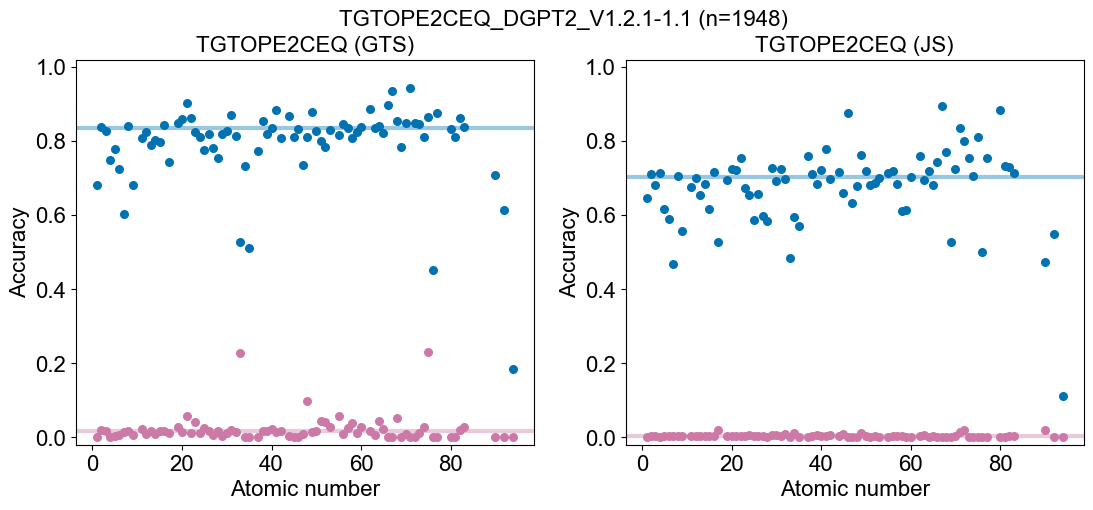

In [34]:
# Plot Configuration
fsize = 16
line_width = 3
msize = 30
ylim = [-0.02, 1.02]  # y-axis limits for accuracy
colors = [good_colors['pink'], good_colors['blue']]  # Colors for different predictions (j=0, j=1)

# Create subplots for each metric (gts, js, etc.)
fig, axs = plt.subplots(1, len(metrics_key), figsize=(13, 5))

# Iterate over each metric (gts, js) and corresponding subplot
for i, metric_key in enumerate(metrics_key):
    ax = axs[i]
    
    # Plot for each prediction (p_text.0, p_text.1)
    for j in range(2):
        c = colors[j]  # Choose color for j=0 and j=1
        
        # Load the element-wise accuracy CSV file for this metric and prediction
        csv_file = f"{save_header}_elem_{metric_key}.{j}.csv"
        df_elem = pd.read_csv(join(save_dir, csv_file), names=['element', 'accuracy'])

        # Get the atomic number for each element
        df_elem['atomic_number'] = df_elem['element'].apply(lambda x: chemical_symbols.index(x) + 1)

        # Scatter plot: atomic number (x-axis) vs accuracy (y-axis)
        ax.scatter(df_elem['atomic_number'], df_elem['accuracy'], color=c, s=msize)

        # Calculate and plot the mean accuracy as a horizontal line
        acc_mean = data[f"{metric_key}.{j}"].mean()
        print(f"{task.upper()} ({metric_key.upper()}) {j}: {acc_mean:.3f}")
        ax.axhline(acc_mean, color=c, linestyle='-', linewidth=line_width, alpha=0.4)

        # Set plot properties
        ax.set_ylim(ylim)
        ax.set_xlabel('Atomic number', fontsize=fsize)
        ax.set_ylabel('Accuracy', fontsize=fsize)
        ax.tick_params(axis='x', labelsize=fsize)
        ax.tick_params(axis='y', labelsize=fsize)
        ax.set_title(f'{task.upper()} ({metric_key.upper()})', fontsize=fsize)
        
        
        from utils.periodic_trends import plotter
        p = plotter(join(save_dir, csv_file), output_filename=join(save_dir, f"{save_header}_elem_{metric_key}.{j}.html"), under_value=0, over_value=1)


# Add a title for the entire figure
fig.suptitle(save_header.upper() + f' (n={len(data)})', fontsize=fsize)

# Save the figure as a PDF file
fig.savefig(join(fig_dir, f"{save_header}_elem_acc.pdf"))


### 8. Loading and Merging Quantum Weight Data

Here, we load quantum weight data from a CSV file, merge it with the existing evaluation data, and filter out rows with missing quantum weights. Finally, we sort the merged data by quantum weight in descending order.


In [27]:
# Load quantum weight data from the CSV file
qw_file = './data/LLMSYNTHESIS_test_quantumweights.csv'
df_qw = pd.read_csv(qw_file)

# Rename columns for consistency
df_qw = df_qw.rename(columns={'mp_id': 'mpid', 'quantum_weight': 'qw'})

# Extract the material IDs (mpid) from the quantum weight data
mpids_qw = df_qw['mpid'].values

# Merge the quantum weight data with the main evaluation data on 'mpid'
data_merged = data.merge(df_qw, on='mpid', how='left')

# Filter the merged DataFrame to only include rows with non-missing quantum weight (qw)
data_qw = data_merged[~data_merged['qw'].isna()]

# Sort the filtered data by quantum weight (qw) in descending order
data_qw = data_qw.sort_values(by='qw', ascending=False)

# Store the sorted quantum weight values as a list
qws = list(data_qw['qw'])


### 9. Plotting Quantum Weight vs. Accuracy

In this section, we visualize the accuracy of model predictions in relation to quantum weight. The first plot shows the scatter plot of accuracy vs. quantum weight, and the second plot shows the accuracy distributions (boxplots) across quantum weight bins.


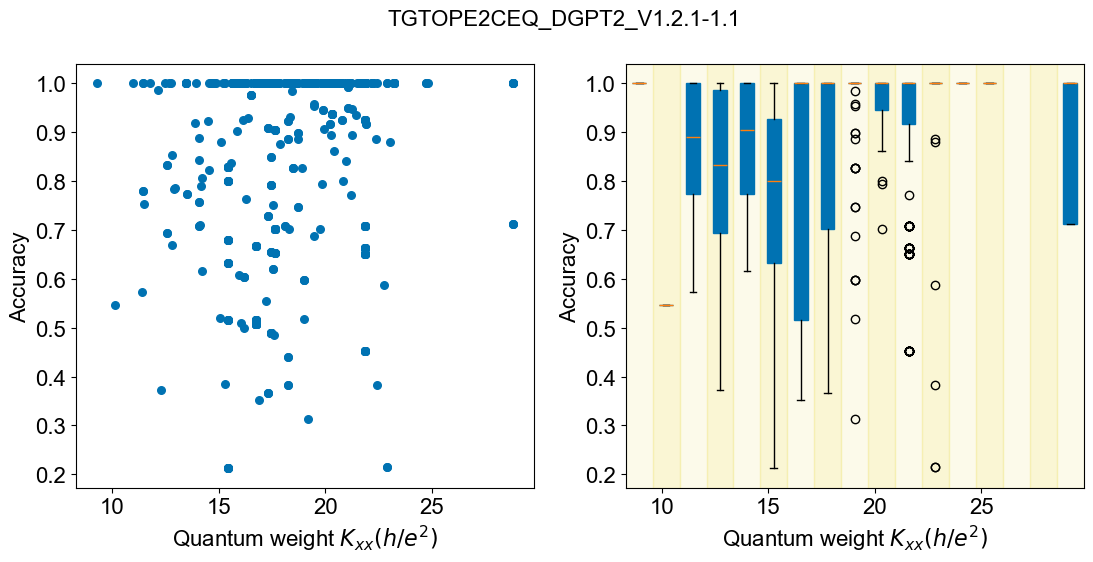

In [28]:
# Create subplots for visualizing quantum weight vs accuracy
fig, axs = plt.subplots(1, 2, figsize=(13, 5.5))

# Labels for the plots
xlabel, ylabel = 'Quantum weight $K_{xx} (h/e^2)$', 'Accuracy'

# First subplot: Scatter plot of accuracy vs quantum weight
ax0 = axs[0]
ax0.scatter(data_qw['qw'], data_qw['gts.1'], color=colors[1], s=msize)
ax0.tick_params(axis='x', labelsize=fsize)
ax0.tick_params(axis='y', labelsize=fsize)
ax0.set_xlabel(xlabel, fontsize=fsize)
ax0.set_ylabel(ylabel, fontsize=fsize)

# Second subplot: Boxplot of accuracy in quantum weight bins
ax1 = axs[1]
xlim = [min(qws) - 1, max(qws) + 1]  # Set x-axis limits
n_window = 18  # Number of quantum weight bins
qw_bins = np.linspace(xlim[0], xlim[1], n_window)
qw_bins_center = (qw_bins[:-1] + qw_bins[1:]) / 2  # Bin centers for plotting

# Initialize lists to store accuracy data for each bin
binned_acc_all = []  # All accuracy values in each bin
binned_acc_avg = []  # Average accuracy in each bin

# Process each bin
for i in range(len(qw_bins) - 1):
    qw_min, qw_max = qw_bins[i], qw_bins[i+1]
    width = qw_max - qw_min
    
    # Create a mask for data points in the current quantum weight bin
    mask = (data_qw['qw'] >= qw_min) & (data_qw['qw'] < qw_max)
    
    # Append average and all accuracy values for the current bin
    binned_acc_avg.append(data_qw[mask]['gts.1'].mean())
    binned_acc_all.append(data_qw[mask]['gts.1'].values)
    
    # Plot boxplot for the current bin
    ax1.boxplot(binned_acc_all[-1], 
                positions=[qw_bins_center[i]], 
                widths=width / 2, 
                patch_artist=True, 
                boxprops=dict(facecolor=colors[1], color=colors[1]), 
                showfliers=True, 
                showmeans=False)
    
    # Highlight the bin region on the plot
    ax1.axvspan(qw_min, qw_max, color=good_colors['yellow'], alpha=0.15 * (i % 2 + 1))
# ax1.scatter(qw_bins_center, qwin_acc_avg, color=colors[1], linewidth=line_width)    #, label=f'{model_name} {metrics_key[0]} 1')

# Set properties for the second plot
ax1.set_xlim(xlim)
ax1.tick_params(axis='x', labelsize=fsize)
ax1.tick_params(axis='y', labelsize=fsize)

# Set custom xticks at specific quantum weight values
specified_ticks = [10, 15, 20, 25]
ax1.set_xticks(specified_ticks)
ax1.set_xticklabels([f"{x}" for x in specified_ticks], fontsize=fsize)

# Labels for the second plot
ax1.set_xlabel(xlabel, fontsize=fsize)
ax1.set_ylabel(ylabel, fontsize=fsize)

# Set the title for the figure and save it
fig.suptitle(save_header.upper(), fontsize=fsize)
fig.savefig(join(fig_dir, f"{save_header}_qw_acc.pdf"))


### 10. Density Plot: Quantum Weight vs Accuracy

In this section, we create a density plot using Seaborn to visualize the relationship between quantum weight (`qw`) and accuracy (`gts.1`). The density plot provides a smooth estimation of the distribution of data points in two dimensions.


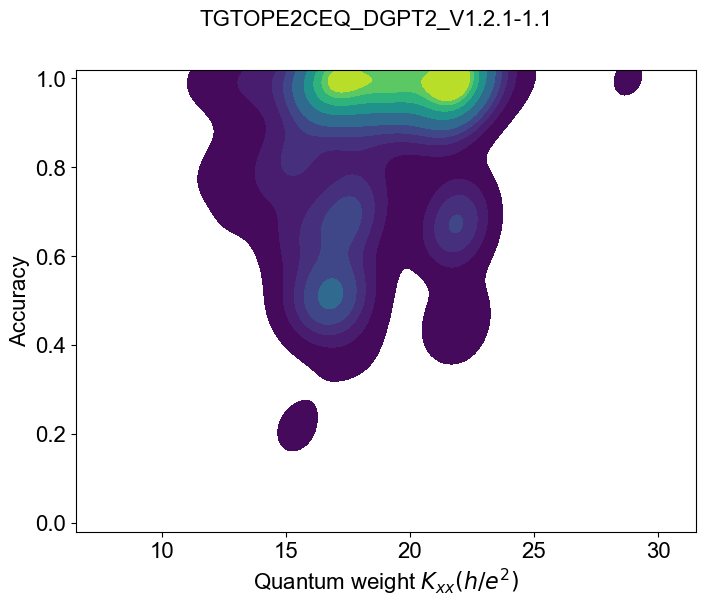

In [30]:
# Import Seaborn for creating the density plot
import seaborn as sns

# Create a density plot to visualize the relationship between quantum weight and accuracy
fig, ax = plt.subplots(figsize=(8, 6))

# Use Seaborn's kdeplot for kernel density estimation with filled contours
sns.kdeplot(data=data_qw, x='qw', y='gts.1', fill=True, ax=ax, cmap='viridis', levels=10)

# Set axis labels and properties
ax.set_xlabel(xlabel, fontsize=fsize)
ax.set_ylabel(ylabel, fontsize=fsize)
ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)

# Set y-axis limit (accuracy cutoff at 1.0)
ax.set_ylim(ylim)

# Set the title and save the figure as a PDF
fig.suptitle(save_header.upper(), fontsize=fsize)
fig.savefig(join(fig_dir, f"{save_header}_qw_acc_density.pdf"))


### 11. Generating LaTeX Table of Top Predictions

Here, we generate a LaTeX table containing the top `1900` predictions based on the `gts.1` metric. The table is saved to a `.tex` file, and the content of the file is printed for review.


In [33]:
# Select the number of top rows to output in the LaTeX table
len_out = 1900
pred_color = 'blue' # Color for the predicted equations in the LaTeX table

# Create a copy of the data and sort it by 'gts.1' in descending order
table = data.copy()
table_save = table.sort_values(by=['gts.1'], ascending=False)[:len_out]

# Specify the output file for the LaTeX table
table_file = f"./tex/si_tab_{save_header}_{len_out}.tex"

# Generate the LaTeX table using the predefined function
generate_latex_table(table_file, task, pred_color, table_save)
print(f"Generated LaTeX table saved to: {table_file}")

# Load and print the generated LaTeX table
with open(table_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        print(line.strip())  # Print each line without extra whitespace


Generated LaTeX table saved to: ./tex/si_tab_tgtope2ceq_dgpt2_v1.2.1-1.1_1900.tex
\begin{longtable}{c|c|p{10cm}|c|c}
\caption{Selected examples of TGTOPE2CEQ}\label{tab_s_tgtope2ceq}\\
No. &  Model & Text & GTS & JS \\
\Xhline{5\arrayrulewidth}
\endfirsthead
\multicolumn{4}{c}{{\tablename\ \thetable{} -- continued from previous page}} \\
No. &  Model & Text & GTS & JS \\
\hline
\endhead
\hline
\multicolumn{4}{r}{{Continued on next page}} \\
\endfoot
\hline
\endlastfoot
1380 & Ground truth & Zr0.53Ti0.47PbO3: Mix Mix Mix Mix Mix $||$ 1 PbO + 0.47 TiO2 + 0.53 ZrO2 $\rightarrow$ 1 Pb(Zr0.53Ti0.47)O3 & 1.0 & 1.0 \\
\hline
1380 & w/ fine-tuning & Zr0.53Ti0.47PbO3: Mix Mix Mix Mix Mix $||$ \textcolor{blue}{1 PbO + 0.47 TiO2 + 0.53 ZrO2 $\rightarrow$ 1 Pb(Zr0.53Ti0.47)O3} & 1.0 & 1.0 \\
\hline
1380 & w/o fine-tuning & Zr0.53Ti0.47PbO3: Mix Mix Mix Mix Mix $||$  \textcolor{blue}{Mix Mix $||$ Mix $||$ Mix $||$ Mix $||$ Mix $||$ Mix $||$ Mix $||$} & 0.0 & 0.0 \\
\Xhline{5\arrayrulewidth}
1391 & 